Javier Alemán Rodríguez

# DengAI: Predicción de la propagación de enfermedades

## Extracción y transformación de datos

### Importación de librerías

Instalamos las librería necesarias mediante uno de los siguientes comandos:

```
pip install [nombre librería]
``` 

```
!pip install [nombre librería]
``` 

```
%pip install [nombre librería]
``` 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split
import seaborn as sns
import sklearn.metrics
from scipy import cluster
from lazypredict.Supervised import LazyRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from sklearn.neighbors import KNeighborsRegressor
from scipy.stats import uniform, randint
from sklearn.metrics import mean_absolute_error

Obtenermos los datos subidos en GitHub y los mostramos

In [2]:
url = 'https://raw.githubusercontent.com/JaviARo/Datasets/main/DengAI'

dengue_labels_train = pd.read_csv(f'{url}/dengue_labels_train.csv')
dengue_features_train = pd.read_csv(f'{url}/dengue_features_train.csv')
dengue_features_test = pd.read_csv(f'{url}/dengue_features_test.csv')

In [3]:
dengue_labels_train.head()

,city,year,weekofyear,total_cases
0,sj,1990,18,4
1,sj,1990,19,5
2,sj,1990,20,4
3,sj,1990,21,3
4,sj,1990,22,6


In [4]:
dengue_features_train.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,1990-04-30,0.12,0.10,0.20,0.18,12.42,297.57,...,32.00,73.37,12.42,14.01,2.63,25.44,6.90,29.40,20.00,16.00
1,sj,1990,19,1990-05-07,0.17,0.14,0.16,0.16,22.82,298.21,...,17.94,77.37,22.82,15.37,2.37,26.71,6.37,31.70,22.20,8.60
2,sj,1990,20,1990-05-14,0.03,0.17,0.16,0.17,34.54,298.78,...,26.10,82.05,34.54,16.85,2.30,26.71,6.49,32.20,22.80,41.40
3,sj,1990,21,1990-05-21,0.13,0.25,0.23,0.24,15.36,298.99,...,13.90,80.34,15.36,16.67,2.43,27.47,6.77,33.30,23.30,4.00
4,sj,1990,22,1990-05-28,0.20,0.26,0.25,0.25,7.52,299.52,...,12.20,80.46,7.52,17.21,3.01,28.94,9.37,35.00,23.90,5.80


In [5]:
dengue_features_test.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,2008,18,2008-04-29,-0.02,-0.02,0.10,0.09,78.60,298.49,...,25.37,78.78,78.60,15.92,3.13,26.53,7.06,33.30,21.70,75.20
1,sj,2008,19,2008-05-06,-0.02,-0.01,0.08,0.07,12.56,298.48,...,21.83,78.23,12.56,15.79,2.57,26.07,5.56,30.00,22.20,34.30
2,sj,2008,20,2008-05-13,-0.00,NaN,0.15,0.09,3.66,299.46,...,4.12,78.27,3.66,16.67,4.43,27.93,7.79,32.80,22.80,3.00
3,sj,2008,21,2008-05-20,NaN,-0.02,0.12,0.13,0.00,299.69,...,2.20,73.02,0.00,15.78,4.34,28.06,6.27,33.30,24.40,0.30
4,sj,2008,22,2008-05-27,0.06,0.04,0.06,0.08,0.76,299.78,...,4.36,74.08,0.76,16.14,3.54,27.61,7.09,33.30,23.30,84.10


## Limpieza de datos

In [6]:
def NumericalDataScaler(df):
  # Selección de columnas numéricas
  numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.to_list()

  preprocessor_RR = ColumnTransformer([('scale', MinMaxScaler(), numeric_cols)],remainder='passthrough')

  df[numeric_cols] = preprocessor_RR.fit_transform(df[numeric_cols])
  return df

def CategoricalToNumerical(df, categorical_cols): 
	le = LabelEncoder()

	for col in categorical_cols: 
		df[col] = le.fit_transform(df[col])    
	return df

In [7]:
X = dengue_features_train.drop(columns=["week_start_date"], axis=1)
X = CategoricalToNumerical(X, ["city"])
X = NumericalDataScaler(X)
X = X.fillna(X.mean())
y = dengue_labels_train['total_cases']
X.head()

,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,1,0.00,0.33,0.58,0.61,0.39,0.40,0.03,0.39,0.35,...,0.06,0.38,0.03,0.26,0.09,0.43,0.21,0.17,0.49,0.03
1,1,0.00,0.35,0.63,0.66,0.32,0.36,0.06,0.47,0.44,...,0.03,0.48,0.06,0.42,0.07,0.57,0.16,0.32,0.69,0.02
2,1,0.00,0.37,0.48,0.69,0.31,0.38,0.09,0.55,0.50,...,0.05,0.59,0.09,0.59,0.06,0.57,0.17,0.35,0.74,0.08
3,1,0.00,0.38,0.58,0.77,0.44,0.49,0.04,0.58,0.54,...,0.02,0.55,0.04,0.57,0.07,0.65,0.20,0.43,0.79,0.01
4,1,0.00,0.40,0.66,0.79,0.48,0.51,0.02,0.65,0.59,...,0.02,0.56,0.02,0.63,0.11,0.80,0.43,0.54,0.84,0.01


## Separación de variables de entrenamiento y test

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

## Selección de características

### SelectKBest

In [9]:
def ApplySelectKBest(X_train, X_test, y_train, k):
	selector = SelectKBest(f_regression, k=k)

	selector.fit_transform(X_train, y_train)
	selector.transform(X_test)

	print(f"Mejores {k} columnas = [")
	for col in selector.get_feature_names_out():
		print(f"  \'{col}\'")
	print("]\n")

In [10]:
ApplySelectKBest(X_train, X_test, y_train, k=1)
ApplySelectKBest(X_train, X_test, y_train, k=6)
ApplySelectKBest(X_train, X_test, y_train, k=10)
ApplySelectKBest(X_train, X_test, y_train, k=15)

Mejores 1 columnas = [
  'reanalysis_min_air_temp_k'
]

Mejores 6 columnas = [
  'city'
  'year'
  'reanalysis_air_temp_k'
  'reanalysis_min_air_temp_k'
  'reanalysis_tdtr_k'
  'station_min_temp_c'
]

Mejores 10 columnas = [
  'city'
  'year'
  'weekofyear'
  'reanalysis_air_temp_k'
  'reanalysis_avg_temp_k'
  'reanalysis_max_air_temp_k'
  'reanalysis_min_air_temp_k'
  'reanalysis_tdtr_k'
  'station_diur_temp_rng_c'
  'station_min_temp_c'
]

Mejores 15 columnas = [
  'city'
  'year'
  'weekofyear'
  'ndvi_ne'
  'ndvi_nw'
  'reanalysis_air_temp_k'
  'reanalysis_avg_temp_k'
  'reanalysis_dew_point_temp_k'
  'reanalysis_max_air_temp_k'
  'reanalysis_min_air_temp_k'
  'reanalysis_specific_humidity_g_per_kg'
  'reanalysis_tdtr_k'
  'station_avg_temp_c'
  'station_diur_temp_rng_c'
  'station_min_temp_c'
]



### Dendrograma

Distancia Media	  13.06


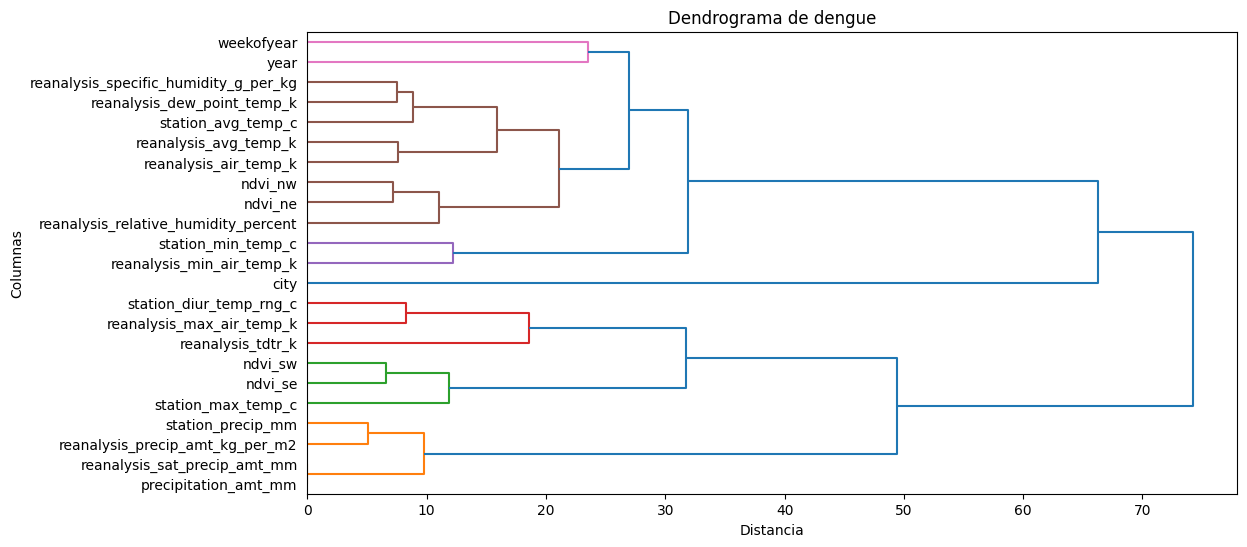

In [11]:
X_T = X.T

dist = sklearn.metrics.DistanceMetric.get_metric('euclidean')
D = dist.pairwise(X_T)
avD = np.average(D)
print("Distancia Media\t {:6.2f}".format(avD))

plt.figure(figsize=(12, 6))
plt.title('Dendrograma de dengue')
plt.xlabel('Distancia')
plt.ylabel('Columnas')
threshold_2 = 26

clusters = cluster.hierarchy.linkage(D, method='complete')
cluster.hierarchy.dendrogram(clusters, color_threshold=threshold_2, labels=X.columns.to_list(), orientation='right')
plt.show()

Se generan 7 grupos, de los cuales cogemos las siguientes caracteristicas:

* Grupo 1: **year** (está entre las mejores 6 columas por SelectKBest)
* Grupo 2: **reanalysis_air_temp_k** (está entre las mejores 6 columas por SelectKBest)
* Grupo 3: **reanalysis_min_air_temp_k** (está entre las mejores 6 columas por SelectKBest)
* Grupo 4: **city** (está entre las mejores 6 columas por SelectKBest)
* Grupo 5: **reanalysis_tdtr_k** (está entre las mejores 6 columas por SelectKBest)
* Grupo 6: **station_min_temp_c** (está entre las mejores 6 columas por SelectKBest)
* Grupo 7: No existe ninguna columna significativa de este grupo entre las 15 mejores columnas

Estas son las 6 características que se escogieron en un inicio, pero dada la poca precision, hemos escogido otras 4 más, dentro de las 10 más significativas de SelectKBest.

In [12]:
# X = X[[
#   'city',
#   'year',
#   'reanalysis_air_temp_k',
#   'reanalysis_min_air_temp_k',
#   'reanalysis_tdtr_k',
#   'station_min_temp_c'
# ]]

X = X[[
  'city',
  'year',
  'weekofyear',
  'reanalysis_air_temp_k',
  'reanalysis_avg_temp_k',
  'reanalysis_max_air_temp_k',
  'reanalysis_min_air_temp_k',
  'reanalysis_tdtr_k',
  'station_diur_temp_rng_c',
  'station_min_temp_c'
]]

### Matriz de correlación

Mostramos la matriz de correlación con las características seleccionadas

**Importante:** La matriz de confusión y su lógica fueron desarrolladas al seleccionar las 6 mejores características, sin embargo y al ver los resultados obtenidos por los modelos y al contar con 10 características he considerado prescindir de usar de nuevo esta herramienta.

Text(0.5, 1.0, 'Matriz de correlación')

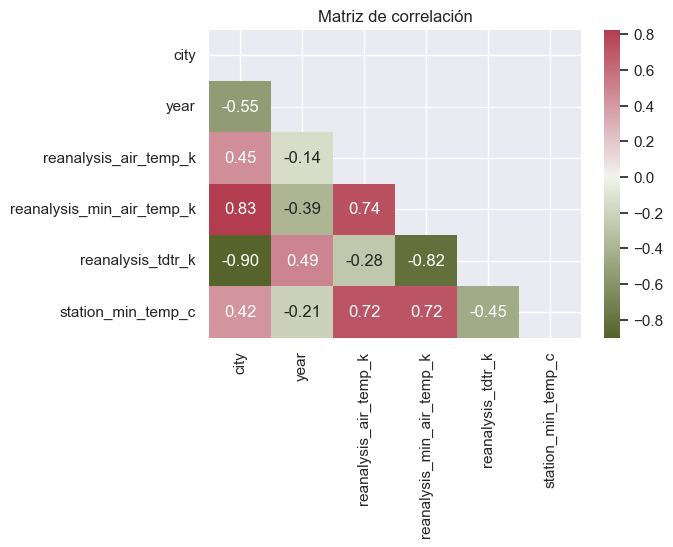

In [14]:
sns.set()

# Calcular la matriz de correlación
corr_mat_data = X.corr()
data_mask = np.triu(np.ones_like(corr_mat_data, dtype = bool)) # Recorta la gráfica

cmap = sns.diverging_palette(100, 7, s = 75, l = 40, n = 5, center = 'light', as_cmap = True)

plt.figure(figsize = (6, 4))
sns.heatmap(corr_mat_data, annot = True, cmap = cmap, fmt = '.2f', center = 0,
            annot_kws = {'size': 12}, mask = data_mask).set_title('Matriz de correlación')

He decidido no quitar ninguna característica más tras mostrar la matriz de correlación por los siguientes motivos:

1. De las dos variables correlacionadas en un 83%, la más propensa a eliminarse es 'reanalysis_min_air_temp' al estar también bien correlacionada con 'station_min_temp_c' y guardar correlación negativa con 'reanalysis_tdtr_k'; no obstante, es la columna con mayor relevancia en el dataset según SelectKBest, por tanto no la quito.
2. Al no conocer en profundidad el tema tratado en los datos, prefiero no quitar caracteristicas por guardar una correlación negativa.

### División de los datos de train, test y validación

El utilizar los datos de validación no me produce buenos resultados con los modelos, así que decidí prescindir de ellos.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.05, random_state=1)

## Selección del modelo

### LazyPredict

Utilizamos la herramienta LazyPredict para determinar los mejores modelos a aplicar

In [14]:
rgr = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = rgr.fit(X_train, X_test, y_train, y_test)

print(models)

100%|██████████| 42/42 [00:02<00:00, 14.67it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000155 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1376
[LightGBM] [Info] Number of data points in the train set: 1164, number of used features: 10
[LightGBM] [Info] Start training from score 25.524914
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
XGBRegressor                                 0.86       0.87 14.62        0.09
DecisionTreeRegressor                        0.77       0.77 19.13        0.01
ExtraTreesRegressor                          0.73       0.74 20.43        0.25
GradientBoostingRegressor                    0.70       0.71 21.73        0.19
LGBMRegressor                                0.67       0.68 22.63        0.04
RandomForestRegressor                        0.66       0.67 22.96        0.50
HistGradientBoostingRegres

## Preparación de los modelos

### Función para aplicar o GridSearch o RandomSearch

Se le pasa el objeto de búsqueda con sus parámetros, X_train, y_train y X_test.

Devuelve el mejor modelo, los mejores parámetros y la predicción, necesaria para calcular el mae.

In [15]:
def applySearch(search, X_train, y_train, X_test):
  search.fit(X_train, y_train)
  y_pred = search.best_estimator_.predict(X_test)
  return [ 
    search.best_estimator_,
    search.best_params_,
    y_pred
	]

### Función para representar la gráfica de los valores predichos y reales

In [22]:
def diffGraphic(y_true, y_pred, title):
	xx = np.arange(y_true.shape[0])
	plt.plot(xx, y_true, c='r', label='data')
	plt.plot(xx, y_pred, c='g', label='prediction')
	plt.axis('tight')
	plt.legend()
	plt.title(title)
	plt.show()

## XGBRegressor

El modelo con mayor puntuación R-Squared por LazyPredict. Es un modelo de árboles que requiere de un número de estimadores.

----------------------- Nº de estimadores 2 -----------------------
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
----------------------- Nº de estimadores 4 -----------------------
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
----------------------- Nº de estimadores 8 -----------------------
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
----------------------- Nº de estimadores 16 -----------------------
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
----------------------- Nº de estimadores 32 -----------------------
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
----------------------- Nº de estimadores 6

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



----------------------- GridSearch -----------------------
Puntuación: 0.8578017074107187
Mejores parámetros: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}


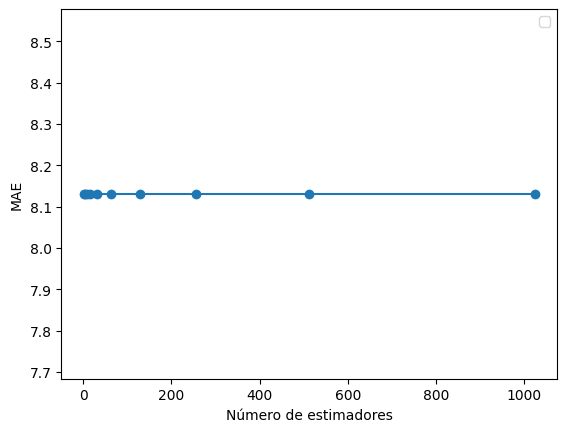

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



---------------------- RandomSearch ----------------------
Puntuación: 0.8732240279293505
Mejores parámetros: {'learning_rate': 0.20145347141948952, 'max_depth': 8, 'n_estimators': 207, 'subsample': 0.935830094847748}


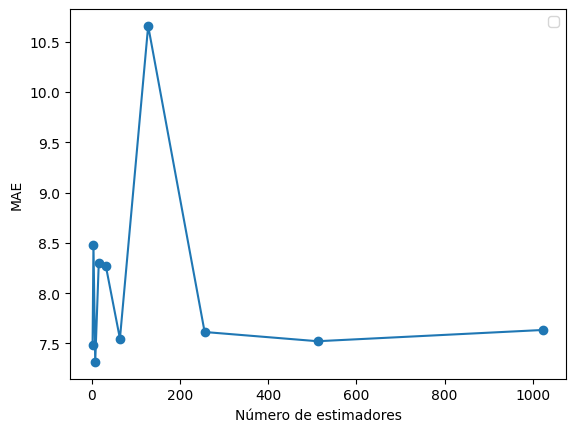

In [17]:
param_grid = {
	'n_estimators': [100, 200, 300],
	'max_depth': [3, 4, 5],
	'learning_rate': [0.01, 0.1, 0.2],
	'subsample': [0.8, 0.9, 1.0]
}

param_dist = {
	'n_estimators': randint(100, 300),
	'max_depth': randint(3, 10),
	'learning_rate': uniform(0.01, 0.2),
	'subsample': uniform(0.8, 0.95)
}

l_estimators = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]

best_models = [[], []]
best_parameters = [[], []]
best_estimators = [[], []]
best_mae = [[], []]
mae = [[], []]
best_scores = [[0], [0]]
y_pred = [[], []]

for estimators in l_estimators:
	print(f"----------------------- Nº de estimadores {estimators} -----------------------")
	model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=estimators, max_depth=3, learning_rate=0.1, random_state=42)

	grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
	search_results = applySearch(grid_search, X_train, y_train, X_test)
	current_score = search_results[0].score(X_test, y_test)
	current_mae = mean_absolute_error(y_test, search_results[2])
	if current_score > best_scores[0]:
		best_scores[0] = current_score
		best_models[0] = search_results[0]
		best_parameters[0] = search_results[1]
		best_estimators[0] = estimators
		y_pred[0] = search_results[2]
		best_mae[0] = current_mae
	mae[0].append(current_mae)

	random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, cv=5, n_jobs=-1, verbose=2)
	search_results = applySearch(random_search, X_train, y_train, X_test)
	current_score = search_results[0].score(X_test, y_test)
	current_mae = mean_absolute_error(y_test, search_results[2])
	if current_score > best_scores[1]:
		best_scores[1] = current_score
		best_models[1] = search_results[0]
		best_parameters[1] = search_results[1]
		best_estimators[1] = estimators
		y_pred[1] = search_results[2]
		best_mae[1] = current_mae
	mae[1].append(current_mae)

print(f"\n----------------------- GridSearch -----------------------")
print(f"Puntuación: {best_scores[0]}")
print(f"Mejores parámetros: {best_parameters[0]}")

plt.plot(l_estimators, mae[0], marker='o')
plt.xlabel('Número de estimadores')
plt.ylabel('MAE')
plt.legend()
plt.show()

print(f"\n---------------------- RandomSearch ----------------------")
print(f"Puntuación: {best_scores[1]}")
print(f"Mejores parámetros: {best_parameters[1]}")

plt.plot(l_estimators, mae[1], marker='o')
plt.xlabel('Número de estimadores')
plt.ylabel('MAE')
plt.legend()
plt.show()

### Distancia entre la predicción y los valores reales

El mejor modelo por puntuación y menor mae se obtuvo por RandomSearch

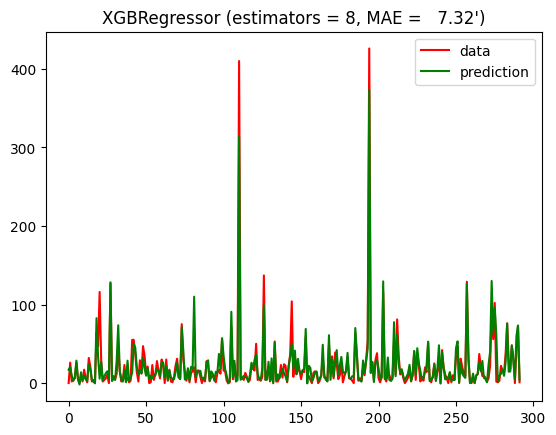

In [23]:
diffGraphic(
  y_test, 
  y_pred[1], 
  "XGBRegressor (estimators = %i, MAE = %6.2f')" % (best_estimators[1], best_mae[1])
)

## DecisionTreeRegressor

El segundo modelo con mayor puntuación R-Squared por LazyPredict. Es un modelo de árboles que no requiere de un número de estimadores, al tratarse de un único árbol por así decirlo.

In [19]:
param_grid = {
	'criterion': ['squared_error', 'friedman_mse', 'absolute_error'],
	'splitter': ['best', 'random'],
	'max_depth': [None, 10, 20, 30],
	'min_samples_split': [2, 5, 10],
	'min_samples_leaf': [1, 2, 4],
	'max_features': [None, 'auto', 'sqrt', 'log2']
}

param_dist = {
	'criterion': ['squared_error', 'friedman_mse', 'absolute_error'],
	'splitter': ['best', 'random'],
	'max_depth': [None, 10, 20, 30],
	'min_samples_split': randint(2, 11),
	'min_samples_leaf': randint(1, 5),
	'max_features': [None, 'auto', 'sqrt', 'log2']
}

model = DecisionTreeRegressor(random_state=42)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
model_1, params_1, y_pred_1 = applySearch(grid_search, X_train, y_train, X_test)
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=50, cv=5, n_jobs=-1, verbose=2, random_state=42)
model_2, params_2, y_pred_2 = applySearch(random_search, X_train, y_train, X_test)

print(f"----------------------- GridSearch -----------------------")
print(f"Puntuación: {model_1.score(X_test, y_test)}")
print(f"Mejores parámetros: {params_1}")
print(f"mae: {mean_absolute_error(y_test, y_pred_1)}")

print(f"---------------------- RandomSearch ----------------------")
print(f"Puntuación: {model_2.score(X_test, y_test)}")
print(f"Mejores parámetros: {params_2}")
print(f"mae: {mean_absolute_error(y_test, y_pred_2)}")

Fitting 5 folds for each of 864 candidates, totalling 4320 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
----------------------- GridSearch -----------------------
Puntuación: 0.7662669460921774
Mejores parámetros: {'criterion': 'squared_error', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'splitter': 'best'}
mae: 10.442066210045661
---------------------- RandomSearch ----------------------
Puntuación: 0.7850243649303131
Mejores parámetros: {'criterion': 'friedman_mse', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'splitter': 'best'}
mae: 9.689097109131355


### Distancia entre la predicción y los valores reales

El mejor modelo por puntuación y menor mae se obtuvo por RandomSearch

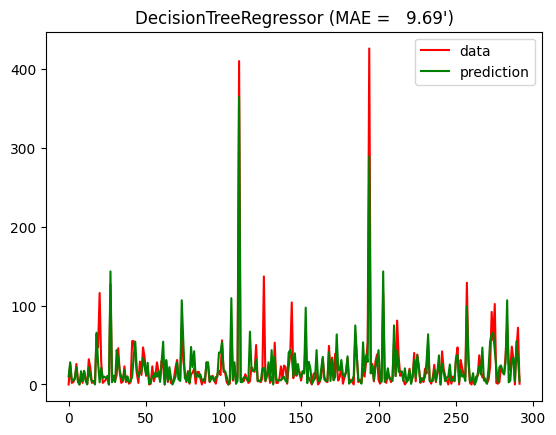

In [24]:
diffGraphic(
  y_test, 
  y_pred_2, 
  "DecisionTreeRegressor (MAE = %6.2f')" % (mean_absolute_error(y_test, y_pred_2))
)

## KNeighborsRegressor

Mejor modelo no de árboles según puntuación R-Squared por LazyPredict.

In [25]:
param_grid = {
	'n_neighbors': [3, 5, 7, 9],
	'weights': ['uniform', 'distance'],
	'metric': ['euclidean', 'manhattan']
}

param_dist = {
	'n_neighbors': randint(3, 10),
	'weights': ['uniform', 'distance'],
	'metric': ['euclidean', 'manhattan']
}

model = KNeighborsRegressor()
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
model_1, params_1, mae_1 = applySearch(grid_search, X_train, y_train, X_test)
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=50, cv=5, n_jobs=-1, verbose=2, random_state=42)
model_2, params_2, mae_2 = applySearch(random_search, X_train, y_train, X_test)

print(f"----------------------- GridSearch -----------------------")
print(f"Puntuación: {model_1.score(X_test, y_test)}")
print(f"Mejores parámetros: {params_1}")
print(f"mae: {mean_absolute_error(y_test, y_pred_1)}")

print(f"---------------------- RandomSearch ----------------------")
print(f"Puntuación: {model_2.score(X_test, y_test)}")
print(f"Mejores parámetros: {params_2}")
print(f"mae: {mean_absolute_error(y_test, y_pred_1)}")

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
----------------------- GridSearch -----------------------
Puntuación: 0.4368565113403756
Mejores parámetros: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}
mae: 10.442066210045661
---------------------- RandomSearch ----------------------
Puntuación: 0.41957374238272827
Mejores parámetros: {'metric': 'manhattan', 'n_neighbors': 8, 'weights': 'distance'}
mae: 10.442066210045661


### Distancia entre la predicción y los valores reales

El mejor modelo por puntuación se obtuvo por GridSearch

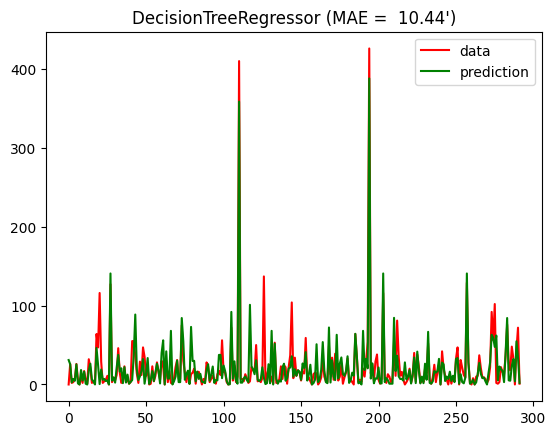

In [26]:
diffGraphic(
  y_test, 
  y_pred_1, 
  "DecisionTreeRegressor (MAE = %6.2f')" % (mean_absolute_error(y_test, y_pred_1))
)

## Predicciones con los datos del archivo de test

Realizamos el escalado, proceso y selección de datos que hicimos con los datos de entrenamiento

In [31]:
X_sub = dengue_features_test.drop(columns=["week_start_date"], axis=1)
X_sub = CategoricalToNumerical(X_sub, ["city"])
X_sub = NumericalDataScaler(X_sub)
X_sub = X_sub.fillna(X_sub.mean())
X_sub = X_sub[[
  'city',
  'year',
  'weekofyear',
  'reanalysis_air_temp_k',
  'reanalysis_avg_temp_k',
  'reanalysis_max_air_temp_k',
  'reanalysis_min_air_temp_k',
  'reanalysis_tdtr_k',
  'station_diur_temp_rng_c',
  'station_min_temp_c'
]]
X_sub.head()

,city,year,weekofyear,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_tdtr_k,station_diur_temp_rng_c,station_min_temp_c
0,1,0.00,0.33,0.53,0.41,0.18,0.76,0.13,0.28,0.60
1,1,0.00,0.35,0.53,0.41,0.16,0.78,0.08,0.14,0.64
2,1,0.00,0.37,0.66,0.51,0.25,0.76,0.23,0.35,0.69
3,1,0.00,0.38,0.70,0.56,0.30,0.79,0.22,0.21,0.82
4,1,0.00,0.40,0.71,0.55,0.26,0.82,0.16,0.28,0.73


### Predicción

Utilizamos el mejor modelo para hacer la predicción

In [32]:
y_pred_sub = best_models[1].predict(X_sub)

### Tabla de subida

In [37]:
submission_table = dengue_features_test[['city','year','weekofyear']]
submission_table['total_cases'] = np.round(y_pred_sub).astype('int32')
submission_table.head()

,city,year,weekofyear,total_cases
0,sj,2008,18,6
1,sj,2008,19,5
2,sj,2008,20,8
3,sj,2008,21,6
4,sj,2008,22,7


### Generamos un archivo csv para subirlo

In [38]:
submission_table.to_csv('submission_table.csv', index=False) 